<a href="https://colab.research.google.com/github/pratik-gond/temp_files/blob/main/elysia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?export=view&id=1wYSMgJtARFdvTt5g7E20mE4NmwUFUuog" width="200">

[![Build Fast with AI](https://img.shields.io/badge/BuildFastWithAI-GenAI%20Bootcamp-blue?style=for-the-badge&logo=artificial-intelligence)](https://www.buildfastwithai.com/genai-course)
[![EduChain GitHub](https://img.shields.io/github/stars/satvik314/educhain?style=for-the-badge&logo=github&color=gold)](https://github.com/satvik314/educhain)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1KxCJz4FIwiiR6kjuk8w8SiQJzu8uZuzB?usp=sharing)
## Master Generative AI in 6 Weeks
**What You'll Learn:**
- Build with Latest LLMs
- Create Custom AI Apps
- Learn from Industry Experts
- Join Innovation Community
Transform your AI ideas into reality through hands-on projects and expert mentorship.
[Start Your Journey](https://www.buildfastwithai.com/genai-course)
*Empowering the Next Generation of AI Innovators

### Elysia Tutorial: From Basics to Advanced (with Students use case)

This tutorial notebook walks you through Elysia — an agentic framework that chooses and runs tools — from the very basics to advanced customization, ending with a practical use case using a Students dataset.

What you'll do:
- Install and configure Elysia
- Create and run a minimal custom tool
- Connect to a Weaviate cluster and preprocess a collection
- Ask natural-language questions over data
- Build an advanced custom tool (linear regression)
- Apply it to a Students dataset to answer a real question

Dataset context: we'll reference a `Student` collection with fields like `Student_ID`, `Gender`, `Study_Hours`, `Attendance`, `Past_Exam`, `Parental_Education`, `Internet_Access`, `Extracurricular`, `Final_Exam`, `Pass_Fail`. Adjust field names if your schema differs.


### 0. Setup and Installation

- This installs `elysia-ai`.
- Keep your keys secret. In Colab, you can use `google.colab.userdata`.

If you're not using Weaviate, you can still run the basic examples.


In [ ]:
# Install core package (quiet to reduce noise)
!pip install -U elysia-ai --quiet

### 1. Configure Elysia

You must configure which models to use and how to access them. Elysia integrates via LiteLLM through DSPy and supports many providers.

- Set your `OPENAI_API_KEY` (or other provider keys) here.
- If using Weaviate Cloud, also set `WCD_URL` and `WCD_API_KEY`.

You can leave Weaviate variables unset to run only the basic examples.


In [2]:
import os
from google.colab import userdata

OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")

from elysia import configure

configure(
    base_model="gpt-4.1-mini",
    base_provider="openai",
    complex_model="gpt-4.1",
    complex_provider="openai",
    openai_api_key=OPENAI_API_KEY,

)

### 2. Basic: Minimal Tool and Tree

A tool is just an async function decorated with `@tool`. The docstring becomes the tool's description.

We'll create `add(x, y)` and call the tree with a simple math question.


In [3]:
from elysia import tool, Tree

# Create a decision tree
basic_tree = Tree()

@tool(tree=basic_tree)
async def add(x: int, y: int) -> int:
    """Return the sum of two integers x and y."""
    return x + y

# Run the tree with a simple prompt
basic_response = basic_tree("What is the sum of 9009 and 6006?")
basic_response


[08/19/25 03:37:02] WARNING  WCD_URL and WCD_API_KEY are not set. All Weaviate functionality will be  ]8;id=448100;file:///usr/local/lib/python3.11/dist-packages/elysia/util/client.py\client.py]8;;\:]8;id=605171;file:///usr/local/lib/python3.11/dist-packages/elysia/util/client.py#151\151]8;;\
                             disabled.                                                                             

╭─────────── User prompt ───────────╮
│                                   │
│ What is the sum of 9009 and 6006? │
│                                   │
╰───────────────────────────────────╯

Output()

╭─────────────────────── Assistant response ────────────────────────╮
│                                                                   │
│ I will calculate the sum of 9009 and 6006 using the add function. │
│                                                                   │
╰───────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── Current Decision ────────────────────────────────────────────────╮
│                                                                                                                 │
│ Node: base                                                                                                      │
│ Decision: add                                                                                                   │
│ Reasoning: The user's prompt is a straightforward arithmetic question asking for the sum of two integers, 9009  │
│ and 6006. Among the available actions, the "add" function is specifically designed to return the sum of two     │
│ integers, making it the most appropriate and direct choice to fulfill the user's request efficiently and        │
│ accurately.                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── Current Decision ────────────────────────────────────────────────╮
│                                                                                                                 │
│ Node: base                                                                                                      │
│ Decision: text_response                                                                                         │
│ Reasoning: The sum of 9009 and 6006 has already been calculated using the add function, resulting in 15015. The │
│ environment confirms this calculation is complete and accurate. Therefore, the next step is to provide the user │
│ with the direct answer to their query using a text response.                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────── Assistant response ────────╮
│                                    │
│ The sum of 9009 and 6006 is 15015. │
│                                    │
╰────────────────────────────────────╯

('I will calculate the sum of 9009 and 6006 using the add function. The sum of 9009 and 6006 is 15015.',
 [[{'tool_result': 15015, '_REF_ID': 'add_default_0_0'}]])

### 3. Connecting to Weaviate (Optional)

If you have a Weaviate Cloud instance, set `WCD_URL` and `WCD_API_KEY` above. Elysia can then query your collections.

We must preprocess a collection so Elysia understands field names, types, and summary context.


In [4]:
!pip install weaviate-client --quiet

In [6]:
# Preprocess collections only if Weaviate credentials are provided to access collecations made in Weaviate
from elysia.preprocess.collection import preprocess

WCD_URL = userdata.get("WCD_URL")
WCD_API_KEY = userdata.get("WCD_API_KEY")

from elysia import configure

configure(
    base_model="gpt-4o-mini",
    base_provider="openai",
    complex_model="gpt-4o",
    complex_provider="openai",
    openai_api_key=OPENAI_API_KEY,
    wcd_url=WCD_URL or None,
    wcd_api_key=WCD_API_KEY or None,
)


In [7]:
if WCD_URL and WCD_API_KEY:
    try:
        preprocess("Student")
        print("Preprocessed 'Student' collection.")
    except Exception as e:
        print("Preprocess skipped or failed:", e)
else:
    print("Weaviate not configured; skipping preprocessing.")


Output()

[08/19/25 03:39:43] INFO     Preprocessed metadata for Student already exists!                    ]8;id=943868;file:///usr/local/lib/python3.11/dist-packages/elysia/preprocess/collection.py\collection.py]8;;\:]8;id=811795;file:///usr/local/lib/python3.11/dist-packages/elysia/preprocess/collection.py#426\426]8;;\

Preprocessed 'Student' collection.


### 4. Querying with Natural Language

Once preprocessed, you can ask questions in natural language. Elysia chooses the right tools (query, aggregate, summarization) to answer.


In [8]:
import elysia

qa_tree = elysia.Tree()

# If Weaviate is configured, pass the collection name(s)
if WCD_URL and WCD_API_KEY:
    qa_response = qa_tree(
        "What is this dataset about?",
        collection_names=["Student"],
    )
else:
    # Without Weaviate, this will still run but won't retrieve data
    qa_response = qa_tree("Describe the goal of this tutorial.")

qa_response


Output()

╭──────── User prompt ────────╮
│                             │
│ What is this dataset about? │
│                             │
╰─────────────────────────────╯

╭─────────────────────────────────────────────── Current Decision ────────────────────────────────────────────────╮
│                                                                                                                 │
│ Node: base                                                                                                      │
│ Decision: text_response                                                                                         │
│ Reasoning: The user is asking about the dataset, which is summarized in the environment. The dataset is about   │
│ student academic performance, including various factors like demographics, study habits, and exam scores. Since │
│ I have the necessary information in the environment, I can provide a concise response to the user's query.      │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── Assistant response ───────────────────────────────────────────────╮
│                                                                                                                 │
│ This dataset focuses on student academic performance, capturing demographics, study habits, and exam scores to  │
│ analyze factors influencing success.                                                                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

('This dataset focuses on student academic performance, capturing demographics, study habits, and exam scores to analyze factors influencing success.',
 [])

### 5. Advanced: Custom Analysis Tool (Linear Regression)

Sometimes you need custom analysis beyond built-in tools. Below we implement a `BasicLinearRegression` tool as a class that Elysia can call. It:
- Extracts numeric fields from retrieved objects in the environment
- Fits a simple linear regression (with intercept) using NumPy
- Returns coefficients to the environment and plots the fit

Theory (very short): for a single feature x and target y, the least-squares solution solves for coefficients β minimizing \(\sum_i (y_i - (β_0 + β_1 x_i))^2\). In matrix form, \(β = (X^T X)^{-1} X^T y\) with X having a leading column of ones for the intercept.


In [9]:
from elysia import Error, Tool, Result
import numpy as np
import matplotlib.pyplot as plt

class BasicLinearRegression(Tool):
    def __init__(self, logger=None, **kwargs):
        super().__init__(
            name="basic_linear_regression_tool",
            description=(
                "Use this tool to perform linear regression between two numeric variables "
                "found in retrieved objects in the environment."
            ),
            status="Running linear regression...",
            inputs={
                "environment_key": {
                    "description": (
                        "A key of the environment to use (e.g., 'query'). "
                        "All objects under that key will be used."
                    ),
                    "required": True,
                    "type": str,
                    "default": None,
                },
                "x_variable_field": {
                    "description": "Independent variable field name.",
                    "required": True,
                    "type": str,
                    "default": None,
                },
                "y_variable_field": {
                    "description": "Dependent variable field name.",
                    "required": True,
                    "type": str,
                    "default": None,
                },
            },
            end=False,
        )

    async def __call__(
        self,
        tree_data,
        inputs,
        base_lm,
        complex_lm,
        client_manager,
        **kwargs,
    ):
        environment = tree_data.environment.environment
        environment_key = inputs["environment_key"]
        x_variable_field = inputs["x_variable_field"]
        y_variable_field = inputs["y_variable_field"]

        try:
            X = np.empty((0, 2))
            y = np.empty((0, 1))

            for inner_key in environment.get(environment_key, {}):
                inner_X = np.array(
                    [
                        [obj[x_variable_field]]
                        for environment_list in environment[environment_key][inner_key]
                        for obj in environment_list["objects"]
                        if x_variable_field in obj and y_variable_field in obj
                    ]
                )
                if inner_X.size == 0:
                    continue
                inner_X = np.hstack([np.ones((inner_X.shape[0], 1)), inner_X])
                X = np.vstack([X, inner_X])

                inner_y = np.array(
                    [
                        [obj[y_variable_field]]
                        for environment_list in environment[environment_key][inner_key]
                        for obj in environment_list["objects"]
                        if x_variable_field in obj and y_variable_field in obj
                    ]
                )
                y = np.vstack([y, inner_y])

            if X.shape[0] == 0:
                yield Error(
                    "No rows with both fields present. Check field names or query step."
                )
                return

            beta_hat = np.linalg.inv(X.T @ X + 1e-10 * np.eye(X.shape[1])) @ X.T @ y
            beta_hat_dict = {
                "intercept": float(beta_hat[0]),
                "slope": float(beta_hat[1]),
            }
            pred_y = X @ beta_hat

            fig, ax = plt.subplots()
            ax.scatter(X[:, 1], y)
            ax.plot(X[:, 1], pred_y, color="red")
            ax.set_title(
                f"Linear regression between {x_variable_field} and {y_variable_field}"
            )
            ax.set_xlabel(x_variable_field)
            ax.set_ylabel(y_variable_field)
            fig.show()

            yield Result(
                objects=[beta_hat_dict],
                metadata={
                    "x_variable_field": x_variable_field,
                    "y_variable_field": y_variable_field,
                },
                llm_message=(
                    "Completed linear regression analysis where: "
                    f"x={x_variable_field}, y={y_variable_field}."
                ),
            )
        except Exception as e:
            yield Error(str(e))

    async def is_tool_available(self, tree_data, base_lm, complex_lm, client_manager):
        return (
            "query" in tree_data.environment.environment
            and len(tree_data.environment.environment["query"]) > 0
        )


### 6. Use case: Students dataset — Do more study hours correlate with final exam score?

We'll:
1) Query the `Student` collection to bring objects into the environment
2) Run `BasicLinearRegression` with `x=Study_Hours` and `y=Final_Exam`

If your schema uses different field names, adjust the strings in the cell below.


Output()

╭────────────────────────── User prompt ──────────────────────────╮
│                                                                 │
│ Retrieve student records with study hours and final exam scores │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────── Assistant response ─────────────────────────────────────────────╮
│                                                                                                             │
│ I will query the "Student" collection to retrieve the records containing study hours and final exam scores. │
│                                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── Current Decision ────────────────────────────────────────────────╮
│                                                                                                                 │
│ Node: base                                                                                                      │
│ Decision: query                                                                                                 │
│ Reasoning: To retrieve student records with study hours and final exam scores, the most appropriate action is   │
│ to use the `query` function, as it allows for retrieving specific data entries from the collections. The        │
│ "Student" collection contains the necessary fields, including "studyHoursPerWeek" and "finalExamScore". Since   │
│ no previous errors have occurred and this is the first attempt, I will proceed with querying the relevant       │
│ collection.                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────── Assistant response ────────────────────────────────╮
│                                                                                    │
│ I will retrieve the student records focusing on study hours and final exam scores. │
│                                                                                    │
╰────────────────────────────────────────────────────────────────────────────────────╯

╭─── Student (Weaviate Query) ────╮
│                                 │
│ collection.query.fetch_objects( │
│     limit=5                     │
│ )                               │
│                                 │
╰─────────────────────────────────╯

╭─────────────────────────────────────── Current Decision ────────────────────────────────────────╮
│                                                                                                 │
│ Node: base.query                                                                                │
│ Decision: query_postprocessing                                                                  │
│ Reasoning: Only one option available: query_postprocessing (and no function inputs are needed). │
│                                                                                                 │
│                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────── Assistant response ──────────────────────────────────────────╮
│                                                                                                        │
│ I will now summarize the retrieved student records, including their study hours and final exam scores. │
│                                                                                                        │
╰────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── Current Decision ────────────────────────────────────────────────╮
│                                                                                                                 │
│ Node: base                                                                                                      │
│ Decision: cited_summarize                                                                                       │
│ Reasoning: The query for student records has been successfully executed, retrieving data that includes study    │
│ hours and final exam scores from the "Student" collection. The next step is to summarize this information for   │
│ the user, as the relevant data has been gathered. This aligns with the user's request to retrieve specific      │
│ records.                                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── Assistant response ───────────────────────────────────────────────╮
│                                                                                                                 │
│ The retrieved student records indicate varying study hours and final exam scores among the students. For        │
│ instance, one student (ID: S037) studied an average of 27 hours per week and scored 59 on the final exam, while │
│ another student (ID: S217) dedicated 38 hours per week and achieved a final exam score of 63. Additionally,     │
│ student S393, who studied 16 hours per week, scored 64 on the final exam. The data shows a range of study       │
│ habits and their corresponding impacts on final exam performance. The records also highlight the pass/fail      │
│ status of the students. For example, students S037 and S209 both failed their final exams despite their study   │
│ efforts, while students S217 and S393 passed. This suggests that study hours alone may not be the sole          │
│ determinant of exam success, as other factors could be influencing the outcomes.                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭─────────────────────── User prompt ───────────────────────╮
│                                                           │
│ Run linear regression with x=Study_Hours and y=Final_Exam │
│                                                           │
╰───────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── Assistant response ───────────────────────────────────────────────╮
│                                                                                                                 │
│ I will now perform linear regression using "Study_Hours" as the independent variable and "Final_Exam" as the    │
│ dependent variable based on the retrieved student records.                                                      │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── Current Decision ────────────────────────────────────────────────╮
│                                                                                                                 │
│ Node: base                                                                                                      │
│ Decision: basic_linear_regression_tool                                                                          │
│ Reasoning: To run linear regression with "Study_Hours" as the independent variable and "Final_Exam" as the      │
│ dependent variable, I will use the `basic_linear_regression_tool`. The necessary data is already available in   │
│ the environment from the previous query, which retrieved student records containing both study hours and final  │
│ exam scores. This is the next logical step to fulfill the user's request.                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── Assistant response ──────────────────────────────────────────────╮
│                                                                                                                │
│ I will now execute the linear regression analysis using the retrieved data for "Study_Hours" and "Final_Exam". │
│                                                                                                                │
╰────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── Current Decision ────────────────────────────────────────────────╮
│                                                                                                                 │
│ Node: base                                                                                                      │
│ Decision: basic_linear_regression_tool                                                                          │
│ Reasoning: The user has requested to run a linear regression with "Study_Hours" as the independent variable and │
│ "Final_Exam" as the dependent variable. The necessary data has already been retrieved from the "Student"        │
│ collection, which includes both study hours and final exam scores. I will now proceed to execute the linear     │
│ regression using the `basic_linear_regression_tool`, as it is the appropriate action for this task.             │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── Assistant response ───────────────────────────────────────────────╮
│                                                                                                                 │
│ I will now execute the linear regression analysis using the `basic_linear_regression_tool` with "Study_Hours"   │
│ as the independent variable and "Final_Exam" as the dependent variable.                                         │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── Current Decision ────────────────────────────────────────────────╮
│                                                                                                                 │
│ Node: base                                                                                                      │
│ Decision: basic_linear_regression_tool                                                                          │
│ Reasoning: The user has requested to run linear regression with "Study_Hours" as the independent variable and   │
│ "Final_Exam" as the dependent variable. The necessary data has already been retrieved from the "Student"        │
│ collection, which includes both study hours and final exam scores. I will now proceed to execute the linear     │
│ regression using the `basic_linear_regression_tool`, as it is the appropriate action for this task.             │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── Assistant response ───────────────────────────────────────────────╮
│                                                                                                                 │
│ The linear regression analysis has been completed, showing an intercept of 58.25 and a slope of 0.08,           │
│ indicating a positive relationship between study hours and final exam scores.                                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── Current Decision ────────────────────────────────────────────────╮
│                                                                                                                 │
│ Node: base                                                                                                      │
│ Decision: cited_summarize                                                                                       │
│ Reasoning: The linear regression analysis has been successfully executed using "Study_Hours" as the independent │
│ variable and "Final_Exam" as the dependent variable. The necessary data was retrieved from the "Student"        │
│ collection, which included both study hours and final exam scores. The regression results indicate an intercept │
│ of approximately 58.25 and a slope of about 0.08, suggesting a positive correlation between study hours and     │
│ final exam scores.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── Assistant response ───────────────────────────────────────────────╮
│                                                                                                                 │
│ The linear regression analysis was conducted with "Study_Hours" as the independent variable and "Final_Exam" as │
│ the dependent variable. The results indicate an intercept of approximately 58.25 and a slope of about 0.08.     │
│ This suggests a positive correlation between study hours and final exam scores, meaning that as study hours     │
│ increase, final exam scores tend to increase as well.                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

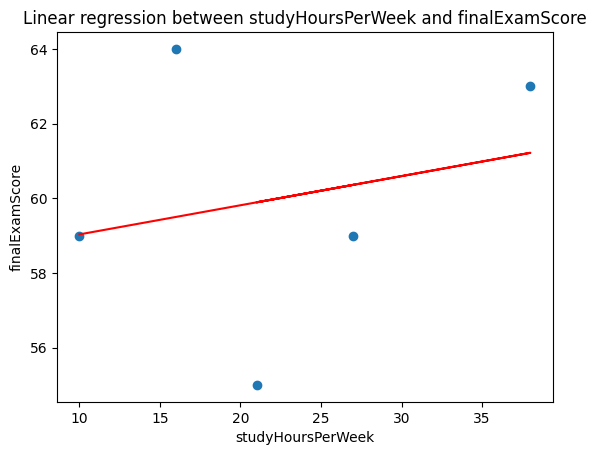

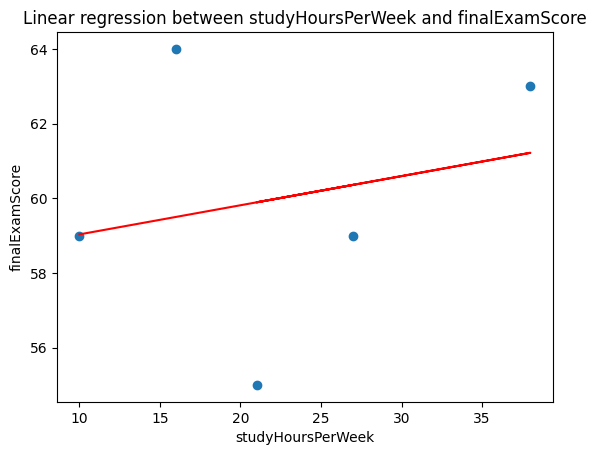

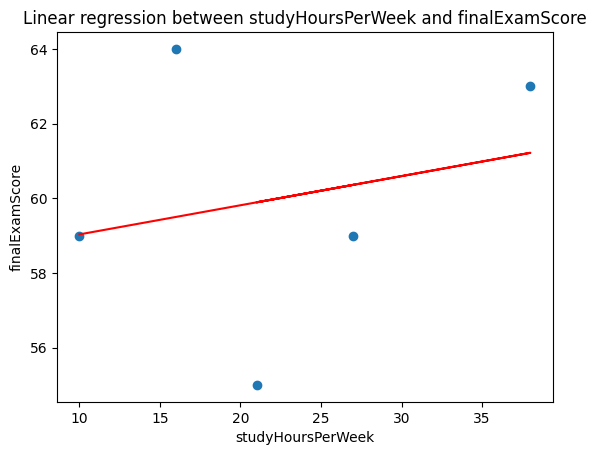

In [10]:
students_tree = elysia.Tree()

# Add our custom tool to the tree
students_tree.add_tool(BasicLinearRegression)

if WCD_URL and WCD_API_KEY:
    # Step 1: bring data into the environment
    response1 = students_tree(
        "Retrieve student records with study hours and final exam scores",
        collection_names=["Student"],
    )

    # Step 2: run the regression tool
    response2 = students_tree(
        "Run linear regression with x=Study_Hours and y=Final_Exam",
        # Hints to the decision agent via the prompt; the tool will still validate fields
    )

    response1, response2
else:
    print("Weaviate not configured; skipping Students use case execution.")


### 7. Interpreting Results

- The tool prints the intercept and slope. A positive slope indicates higher `Study_Hours` is associated with higher `Final_Exam`.
- The scatterplot displays data points with a red best-fit line.
- Always validate with domain knowledge; correlation does not imply causation.

Next steps:
- Try different x/y fields (e.g., `Attendance` vs `Final_Exam`)
- Add categorical handling or multi-feature regression
- Build more tools for diagnostics (R², residual analysis)
